# Combined Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 8g --executor-memory 8g
```

At this point, we've got several sets of data processed and cleaned. We also have discovered several fields we can use for joining:

- license_id
- longitude, latitude

Longitude and latitude are great candidates for joining crime, sanitation, weather, and inspections. The problem is that it's not reasonable to expect them to fall on exactly the same coordinate.

Suppose we divided the city up into a grid and determined the coordinates for the center of each cell. Then, we could determine which sanitation complaints and crimes were committed in the cell, and connect that to inspections.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark.sql.functions import lit, col, coalesce, when
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
import pyspark

from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

# Cross Validation

Now that we're ready to build a model, let's think about our approach. How do we know if the model will be any good? How do we know it will even be any better than just randomly guessing?

No matter which model we choose, we'll need to be able to compare them. There are many measures, but one simple one in classification problems is accuracy. Accuracy is simply the proportion of how predictions were right vs wrong. The approach we'll opt to use is a simple test-train split. That means we use some of our data to train the model, then use the other data we set aside to test its accuracy. We don't want to check accuracy against the training data, becsause if we overfit (meaning we are trained to only be good at pridicting this set of data, and not future data), we'll never know.

We'll start by taking our full set and splitting it 75/25

In [3]:
df_full = sqlContext.read.format('parquet').load('full_set')

In [4]:
df_full.dtypes

[('city_grid', 'int'),
 ('y', 'int'),
 ('y_fail', 'int'),
 ('canvass', 'int'),
 ('complaint', 'int'),
 ('cumulative_failures', 'int'),
 ('cumulative_inspections', 'int'),
 ('days_since_last_inspection', 'int'),
 ('ever_failed', 'int'),
 ('inspection_type', 'int'),
 ('license_related', 'int'),
 ('liquor', 'int'),
 ('prev_fail', 'int'),
 ('proportion_past_failures', 'double'),
 ('recent_inspection', 'int'),
 ('reinspection', 'int'),
 ('special_event', 'int'),
 ('task_force', 'int'),
 ('monthVec', 'vector'),
 ('weekdayVec', 'vector'),
 ('riskVec', 'vector'),
 ('wardVec', 'vector'),
 ('police_districtVec', 'vector'),
 ('conditional_approval', 'int'),
 ('crime_count_theft', 'bigint'),
 ('crime_count_burglary', 'bigint'),
 ('crime_count_other', 'bigint'),
 ('sanitation_violation_count', 'bigint'),
 ('TMAX', 'int'),
 ('TMIN', 'int'),
 ('TMAX_3', 'double'),
 ('TMAX_5', 'double')]

In [5]:
df_full = df_full.drop("city_grid").drop("y")

In [6]:
df_train, df_test = df_full.randomSplit([.75, .25], 24)

In [7]:
df_train.count()

57729

In [8]:
df_test.count()

19170

In [9]:
df_train.columns

['y_fail',
 'canvass',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_type',
 'license_related',
 'liquor',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'special_event',
 'task_force',
 'monthVec',
 'weekdayVec',
 'riskVec',
 'wardVec',
 'police_districtVec',
 'conditional_approval',
 'crime_count_theft',
 'crime_count_burglary',
 'crime_count_other',
 'sanitation_violation_count',
 'TMAX',
 'TMIN',
 'TMAX_3',
 'TMAX_5']

# Baseline Model

As we mentioned above, we still have to ask... sure that number is great... is it any better than just guessing? So, as a baseline model, let's just say we will predict that everyone fails.

In [10]:
accuracy = df_test.select("y_fail").withColumn("y_pred", lit(1)).filter(col("y_fail") == col("y_pred")).count() / float(19170) * 100

In [11]:
print "Baseline Model Accuracy: %.2f%%" % accuracy

Baseline Model Accuracy: 20.47%


If we say that everyone fails, we'll only be right 20.47% of the time.

# Preparing the  Model

We've got a little work to do to get spark.ml to be able to process our data. First, we'll index the label (our actual pass/fail) that we're training on.

In [12]:
labelIndexer = StringIndexer(inputCol="y_fail", outputCol="label")

Next, we'll record our columns. We'll use one for the indexing the features. Remember when we one-hot encoded a few columns? We'll need another list of columns so that we can decode them back (the second array). We could broadcast these, but we'll keep it simple since this training is a one-time thing.

In [13]:
#broadcast this?
feature_cols = ['canvass',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_type',
 'license_related',
 'liquor',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'special_event',
 'task_force',
 'monthVec',
 'weekdayVec',
 'riskVec',
 'conditional_approval',
 'wardVec',
 'police_districtVec',
 'crime_count_theft',
 'crime_count_burglary',
 'crime_count_other',
 'sanitation_violation_count',
 'TMAX',
 'TMIN',
 'TMAX_3',
 'TMAX_5']

In [14]:
full_feature_set = [
   'canvass',
 'complaint',
 'cumulative_failures',
 'cumulative_inspections',
 'days_since_last_inspection',
 'ever_failed',
 'inspection_type',
 'license_related',
 'liquor',
 'prev_fail',
 'proportion_past_failures',
 'recent_inspection',
 'reinspection',
 'special_event',
 'task_force',
 'month_jan','month_feb','month_march','month_april','month_may','month_june','month_july','month_august','month_sept','month_oct','month_nov','month_dec',
 'weekday_mon','weekday_tues','weekday_weds','weekday_thurs','weekday_fri','weekday_sat',
 'risk_high','risk_med','risk_low',
 'conditional_approval',
 'ward_1',
 'ward_2',
 'ward_3',
 'ward_4',
 'ward_5',
 'ward_6',
 'ward_7',
 'ward_8',
 'ward_9',
 'ward_10',
 'ward_11',
 'ward_12',
 'ward_13',
 'ward_14',
 'ward_15',
 'ward_16',
 'ward_17',
 'ward_18',
 'ward_19',
 'ward_20',
 'ward_21',
 'ward_22',
 'ward_23',
 'ward_24',
 'ward_25',
 'ward_26',
 'ward_27',
 'ward_28',
 'ward_29',
 'ward_30',
 'ward_31',
 'ward_32',
 'ward_33',
 'ward_34',
 'ward_35',
 'ward_36',
 'ward_37',
 'ward_38',
 'ward_39',
 'ward_40',
 'ward_41',
 'ward_42',
 'ward_43',
 'ward_44',
 'ward_45',
 'ward_46',
 'ward_47',
 'ward_48',
 'ward_49', 'ward_50','district_1',
 'district_2',
 'district_3',
 'district_4',
 'district_5',
 'district_6',
 'district_7',
 'district_8',
 'district_9',
 'district_10',
 'district_11',
 'district_12',
 'district_13',
 'district_14',
 'district_15',
 'district_16',
 'district_17',
 'district_18',
 'district_19',
 'district_20',
 'district_21',
 'district_22',
 'district_23',
 'district_24', 'district_25',
 'crime_count_theft',
 'crime_count_burglary',
 'crime_count_other',
 'sanitation_violation_count',
 'TMAX',
 'TMIN',
 'TMAX_3',
 'TMAX_5' 
]

Now, we assemble our feature columns into a single Sparse Vector (https://spark.apache.org/docs/1.1.0/mllib-data-types.html)

In [16]:
featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

A pipeline is used to compose our functions. Remember that Spark doesn't execute these until an action is taken... that will be `fit` below

In [17]:
pipeline = Pipeline(stages=[featureAssembler, labelIndexer])

In [18]:
data = pipeline.fit(df_full).transform(df_full)
data.cache()

DataFrame[y_fail: int, canvass: int, complaint: int, cumulative_failures: int, cumulative_inspections: int, days_since_last_inspection: int, ever_failed: int, inspection_type: int, license_related: int, liquor: int, prev_fail: int, proportion_past_failures: double, recent_inspection: int, reinspection: int, special_event: int, task_force: int, monthVec: vector, weekdayVec: vector, riskVec: vector, wardVec: vector, police_districtVec: vector, conditional_approval: int, crime_count_theft: bigint, crime_count_burglary: bigint, crime_count_other: bigint, sanitation_violation_count: bigint, TMAX: int, TMIN: int, TMAX_3: double, TMAX_5: double, features: vector, label: double]

Now, we'll split the data again, using the same random seed, which should give us the same random selections as above.

In [19]:
train, test = data.randomSplit([0.75,0.25], seed=24) # need to ensure same split for each time (and with the baseline)

Normally, we really want the labeled classes for our data to be evenly split. 50/50 would be ideal. Let's see what we have.

In [20]:
train.filter(col("y_fail")==1).count()/float(train.count())

0.21091652375755687

In [21]:
train.filter(col("y_fail")==0).count()/float(train.count())

0.7890834762424431

So, we've got many more passes than fails. That's reasonable or else the city would have a crisis on its hands. We have a few options. One way is to randomly add duplicates from the failed group until we have an even proportion (called Bagging... see https://en.wikipedia.org/wiki/Bootstrap_aggregating). Another approach is to weight them we'll try that below.

In [22]:
def reportAccuracy(metrics):
    print metrics.accuracy
    matrix = metrics.confusionMatrix().toArray()
    print matrix
    plt.figure(figsize = (3,3))
    sn.heatmap(matrix, annot=True, fmt="g")
    plt.xlabel("True")
    plt.ylabel("Predicted")

In [23]:
def reportResults(rdd, model):
    fig = plt.figure(figsize=(12, 4))
    ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
    ax2= plt.subplot2grid((1, 5), (0, 3), colspan=3)
    
    metrics = MulticlassMetrics(rdd)

    print metrics.accuracy
    matrix = metrics.confusionMatrix().toArray()
    print matrix
    
    sn.heatmap(matrix, annot=True, fmt="g", ax=ax1)
    ax1.set_xlabel("True")
    ax1.set_ylabel("Predicted")

    # Include only the 10 most important predictors
    df_importance = pd.DataFrame(model.featureImportances.toArray())
    df_importance.columns = ["importance"]
    df_importance["names"] = full_feature_set
    
    df_importance.sort_values("importance", ascending=False, inplace=True)
    df_importance = df_importance.head(10)
    ax2.barh(range(1,11),df_importance["importance"],align='center', color = "darkblue", alpha = 0.6)
    ax2.set_yticklabels(df_importance["names"])
    ax2.set_yticks(range(1,11))
    ax2.set_xlabel('Relative Importance in the Model')
    ax2.set_ylabel('Features')
    ax2.set_title('Relative importance of Each Feature')

# Decision Tree

A decision tree is a classification method that builds a decision tree for predicting the label. (https://en.wikipedia.org/wiki/Decision_tree_learning).

In [24]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

0.913145539906
[[ 14808.    438.]
 [  1227.   2697.]]


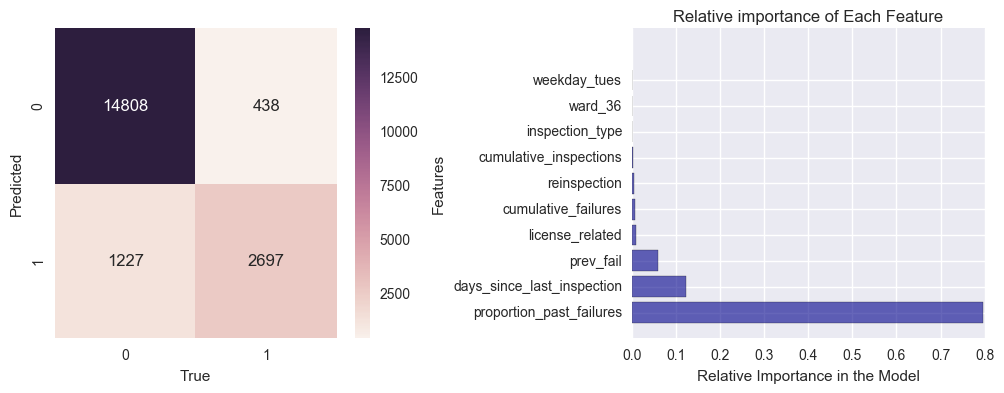

In [25]:
model = dt.fit(train)
predictions = model.transform(test)
reportResults(predictions.select("prediction", "label").rdd, model)

As we can see, it does a reasonable job. For the first split, it used `proportion_past_failures`, then `days_since_last_inspection` and so on. You can see why the intuition that beyond 5 levels deep, we really aren't adding much value. That makes sense. If you fail a lot, then you'll probably fail again... that's probably the gut feeling inspectors get. But, why not split on prev_fail first? If the data looked slightly differently, we may have.

The matrix on the left is called a Confusion Matrix. It shows us how often we got each classification right and wrong. For example, the lower right is out "false positive" quadrant. It's the number of times we said it was a fail (1) but was actually a pass (0).

# Random Forest Classification

Random Forest (https://en.wikipedia.org/wiki/Random_forest) addresses that concern by creating many trees, and combining their results in a sort of "voting" process. That makes it less susceptible to overfitting.

In [26]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500)

0.865414710485
[[  1.52450000e+04   1.00000000e+00]
 [  2.57900000e+03   1.34500000e+03]]


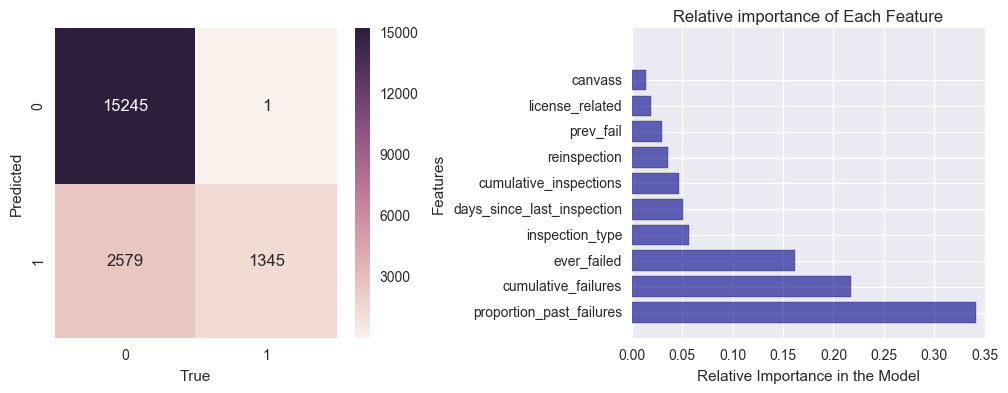

In [27]:
model = rf.fit(train)
predictions = model.transform(test)
reportResults(predictions.select("prediction", "label").rdd, model)

# Logistic Regression

Logistic Regression doesn't use trees, but rather uses "priors" to determine a probability of being in one of the labeled classes (https://en.wikipedia.org/wiki/Logistic_regression). That might be useful for us if we want to sort them by likelihood of being in a class.

In [28]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [29]:
model = lr.fit(train)
predictions = model.transform(test)

0.795305164319
[[ 15246.      0.]
 [  3924.      0.]]


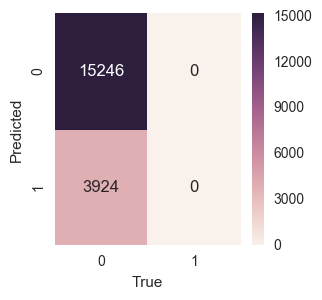

In [30]:
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)
reportAccuracy(metrics)

Unfortunately, it performs terribly. It never gets fails right (those are the ones we care about most). That's because our data is imbalanced, and since we have more passes, it's going to lean toward passing. Let's see if we can weight fails more and passes less to get a better prediction.

In [33]:
count = predictions.count()
l = predictions.select("label").toPandas()

In [34]:
count / (2 * np.bincount(l["label"].astype("int64")))

array([0, 2])

In [35]:
weighted_train = train.withColumn("logistic_weights", when(col("label")==0.0, 0.25).otherwise(0.75))

In [43]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, weightCol="logistic_weights")

In [44]:
model = lr.fit(weighted_train)
predictions = model.transform(test)

0.875169535733
[[ 15065.    181.]
 [  2212.   1712.]]


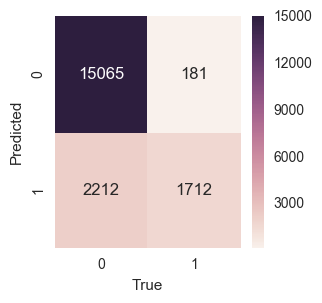

In [38]:
metrics = MulticlassMetrics(predictions.select("prediction", "label").rdd)
reportAccuracy(metrics)

Much better!

# Gradient Boosted Trees

I'll leave you to read about GBT (https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting), but it's no accident that I left it for last. It performed best.

In [39]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100)

0.914919144497
[[ 14816.    430.]
 [  1201.   2723.]]


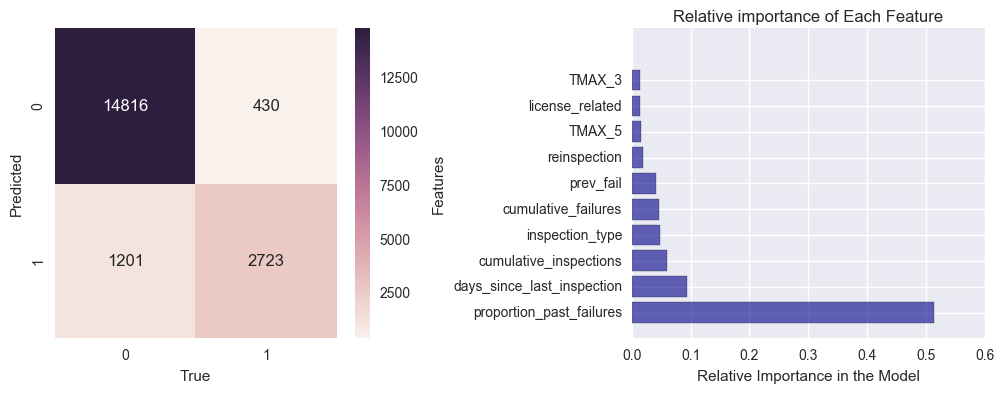

In [40]:
gbt_model = gbt.fit(train)
predictions = gbt_model.transform(test)
reportResults(predictions.select("prediction", "label").rdd, gbt_model)

# Choosing our model

Purely using accuracy in our case is problematic. We don't want a perfectly accurate model (in fact if it is, you should be worried). What we're trying to accomplish is to determine an inspection order that would reduce the liklihood of people getting sick. That means we want to catch as many failures as soon as we can. That requires a balance. We're not all that worried about over-predicting false negatives, unless they spam our inspection list. GBT did the best overall, but let's take a look at how it got there. It predicted 3924 fails, but missed 430 fails. 

Weighted logistic regression did just as well at predicting those 3924 fails, but it only missed 181 false negatives. So, even though it had a lower total accuracy, it had a more impactful one for our case... and as a bonus, we can use the prior probability as a sort order for inspections. We can also use proportion of past failures, which we would have to have used in the tree approach.

In [41]:
model.featureImportances

SparseVector(120, {0: 0.0018, 1: 0.0133, 2: 0.046, 3: 0.0593, 4: 0.0942, 5: 0.0, 6: 0.0471, 7: 0.0143, 9: 0.0411, 10: 0.5132, 11: 0.0006, 12: 0.0182, 16: 0.0, 17: 0.0005, 18: 0.0043, 19: 0.0046, 20: 0.0011, 21: 0.001, 22: 0.0008, 24: 0.0006, 25: 0.0013, 26: 0.002, 27: 0.0026, 28: 0.0011, 29: 0.0005, 30: 0.0017, 31: 0.0059, 32: 0.0018, 34: 0.0001, 35: 0.0015, 36: 0.0006, 39: 0.0023, 40: 0.0007, 42: 0.0, 43: 0.0011, 45: 0.0001, 49: 0.0005, 51: 0.0014, 52: 0.0016, 54: 0.0011, 57: 0.0002, 60: 0.0004, 62: 0.0004, 64: 0.0021, 65: 0.0005, 66: 0.0013, 67: 0.0031, 69: 0.0002, 71: 0.0014, 72: 0.0013, 75: 0.0052, 76: 0.002, 77: 0.0025, 81: 0.0005, 86: 0.0009, 90: 0.0, 91: 0.0004, 94: 0.001, 95: 0.0006, 98: 0.0, 99: 0.0002, 101: 0.0018, 102: 0.0002, 104: 0.0003, 105: 0.0008, 111: 0.0022, 112: 0.0097, 113: 0.0052, 114: 0.0062, 115: 0.0121, 116: 0.0124, 117: 0.0055, 118: 0.0137, 119: 0.0157})

In [42]:
gbt_model.save("final_model")

In [45]:
model.save("final_model_lr")